# <center>Scaling XGBoost Hyper-Parameter Optimization</center>

<img src="images/swarm.png" width="400"/>

# Motivation:

To reach highest performance in classification tasks (i.e., supervised learning ), it is best practice to build an ensemble of champion models. 

Each member of the ensemble is a winner of a search over many models of its kind with altered hyper-parameters.

In this notebook, we build a harness for running such a [hyper-parameter] search to demonstrate the accuracy benefits while exploring performance as we scale within and accross GPU nodes.

# Library Imports:

In [1]:
import ipyvolume as ipv
import matplotlib.pyplot as plt

import numpy as np; import pandas as pd; import cudf
import cuml; import xgboost; from xgboost import plot_tree
import warnings; warnings.filterwarnings('ignore')

import time; import copy 

import data_utils
import swarm
import visualization as viz

# reload library modules/code without a kernel restart
import importlib; importlib.reload( swarm ); importlib.reload( data_utils ); importlib.reload( viz);

# Dataset:

<center> In this notebook you can try different hyper-parameter search methods using synthetic or real data. </center>
 
&nbsp;

| method name | &nbsp;&nbsp;&nbsp; performance | &nbsp;&nbsp;&nbsp; search duration  |
|-----------------------|-----------------|------------------|
| random-search         | &nbsp;&nbsp;&nbsp; worst | &nbsp;&nbsp;&nbsp; slow    |
| particle-search [1]      | &nbsp;&nbsp;&nbsp; good  | &nbsp;&nbsp;&nbsp; fast    |
| async-particle-search | &nbsp;&nbsp;&nbsp; best  | &nbsp;&nbsp;&nbsp; fastest |

<center>[1] https://en.wikipedia.org/wiki/Particle_swarm_optimization#Algorithm</center>


<img src="images/datasets.png" width="800"/>

# [ Optional ] Synthetic Dataset Demo

gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, gen coil = 4800, 

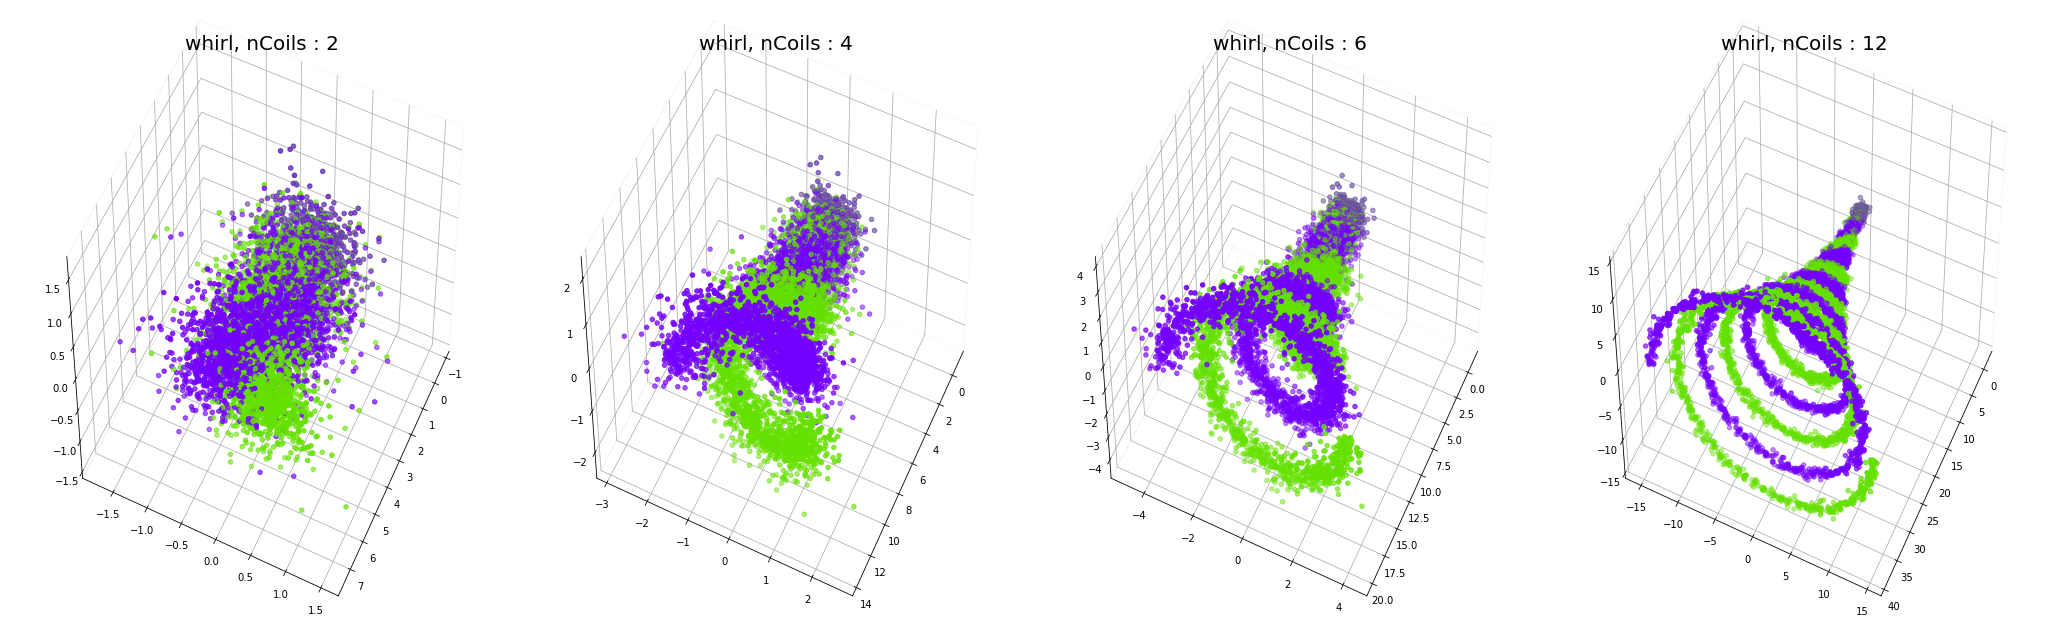

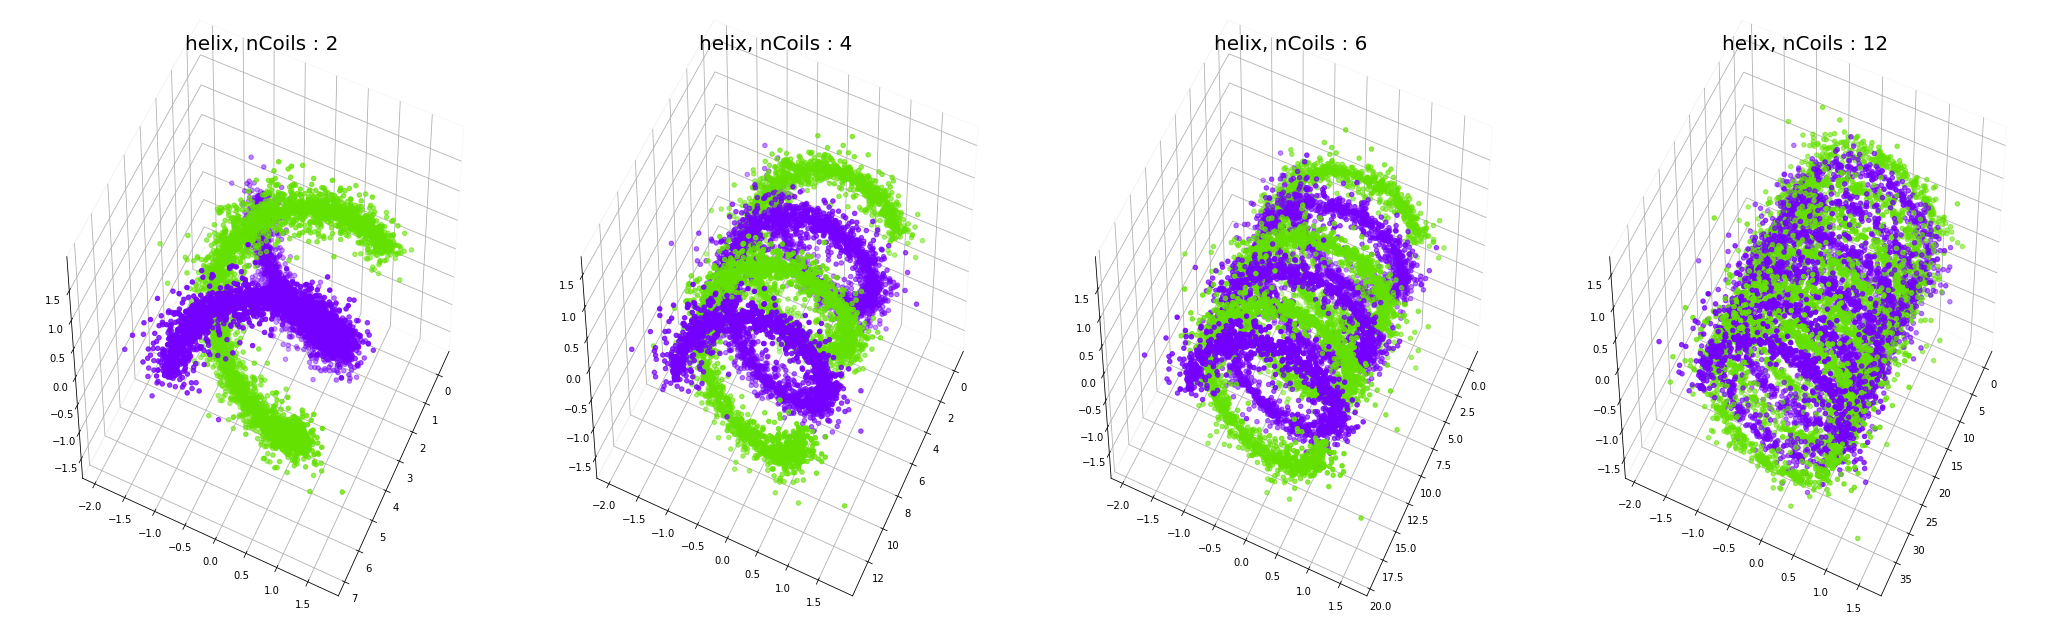

In [2]:
exploreSyntheticDataFlag = True
if exploreSyntheticDataFlag:
    viz.visualize_synthetic_data_variants('whirl', nSamples = 10000, sdevScales = [ .3, .3, .3], nCoils = [2, 4, 6, 12])
    viz.visualize_synthetic_data_variants('helix', nSamples = 10000, sdevScales = [ .1, .1, .1], nCoils = [2, 4, 6, 12])

# Import / Generate Data

In [3]:
#dataset = data_utils.Dataset('fashion-mnist')
#dataset = data_utils.Dataset('airline')
dataset = data_utils.Dataset('synthetic')

gen coil = 50000, gen coil = 50000, 
splitting data into training and test set
rescaling data
rescaling data


In [4]:
viz.plot_data( dataset.data, dataset.labels, dataset.datasetName )

plotting SYNTHETIC dataset, original shape: (100000, 3)


# Define Compute Cluster

In [5]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster

from dask.distributed import Client
from dask.distributed import as_completed
from dask.distributed import worker

In [6]:
cluster = LocalCUDACluster( ip = '', n_workers = 4)

In [7]:
client = Client( cluster, asynchronous = True)

In [8]:
client

Client Scheduler: tcp://172.17.0.2:32823 Dashboard: http://172.17.0.2:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


# Define HPO XGBoost Search Ranges

In [9]:
paramRanges = { 0: ['max_depth', 3, 20, 'int'],
                1: ['learning_rate', .001, 1, 'float'],
                2: ['gamma', 0, 2, 'float'] }

# Sync vs Async [ Dask Task Stream ]

<img src='images/sync_vs_async.PNG' width='1000px'>

# Build and Run Synchronous Swarm

In [10]:
syncSwarm = swarm.SyncSwarm( client, dataset, paramRanges, nEpochs = 10 )

In [11]:
syncSwarm.run_search()

new global best 0.84940 found by particle 0, at eval 0
new global best 0.85370 found by particle 1, at eval 1
new global best 0.88440 found by particle 2, at eval 2
new global best 0.89520 found by particle 3, at eval 3
new global best 0.90000 found by particle 10, at eval 10
new global best 0.90720 found by particle 12, at eval 12
new global best 0.91320 found by particle 5, at eval 21
new global best 0.93100 found by particle 14, at eval 30
new global best 0.94180 found by particle 2, at eval 114
best accuracy: 0.9418, 
	 > params : [16.76636633  0.19973576  1.50462384], nTrees: 35
elapsed time : 43.45065379142761


In [12]:
syncSwarm.globalBest

{'accuracy': 0.9418,
 'particleID': 2,
 'params': array([16.76636633,  0.19973576,  1.50462384]),
 'nTrees': 35,
 'iEvaluation': 8}

# Viz

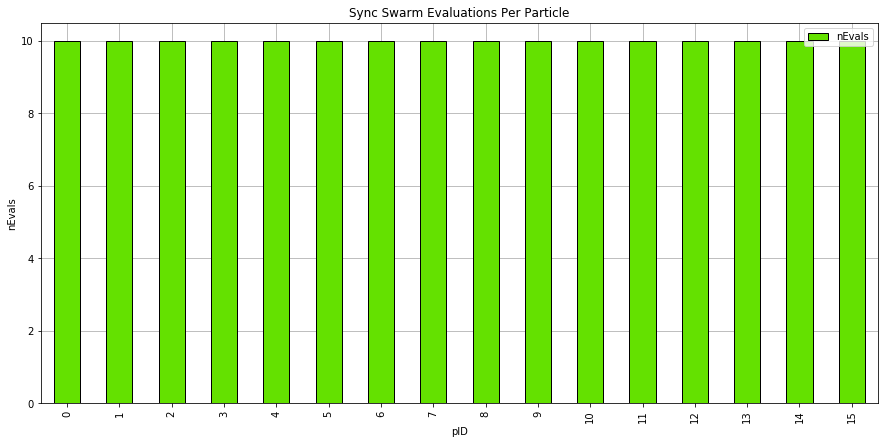

In [13]:
viz.plot_particle_evals( syncSwarm )

In [14]:
viz.viz_particle_trails( syncSwarm )

elapsed time 2.69


In [15]:
viz.viz_swarm(syncSwarm, syncSwarm.paramRanges)

# Build and Run Asynchronous Swarm

In [16]:
asyncSwarm = swarm.AsyncSwarm( client, dataset, paramRanges, nEpochs = 30 )

In [17]:
asyncSwarm.run_search()

new global best 0.37200 found by particle 8, at eval 0
new global best 0.88450 found by particle 13, at eval 2
new global best 0.90710 found by particle 8, at eval 3
new global best 0.90850 found by particle 6, at eval 25
new global best 0.92160 found by particle 12, at eval 37
new global best 0.92570 found by particle 0, at eval 38
new global best 0.92770 found by particle 5, at eval 190
new global best 0.92950 found by particle 4, at eval 231
new global best 0.93510 found by particle 0, at eval 452
best accuracy: 0.9351, 
	 > params : [14.70061925  0.34997608  1.26989825], nTrees: 19
elapsed time : 94.99425148963928


In [18]:
asyncSwarm.globalBest

{'accuracy': 0.9351,
 'particleID': 0,
 'params': array([14.70061925,  0.34997608,  1.26989825]),
 'nTrees': 19,
 'iEvaluation': 21}

# Viz

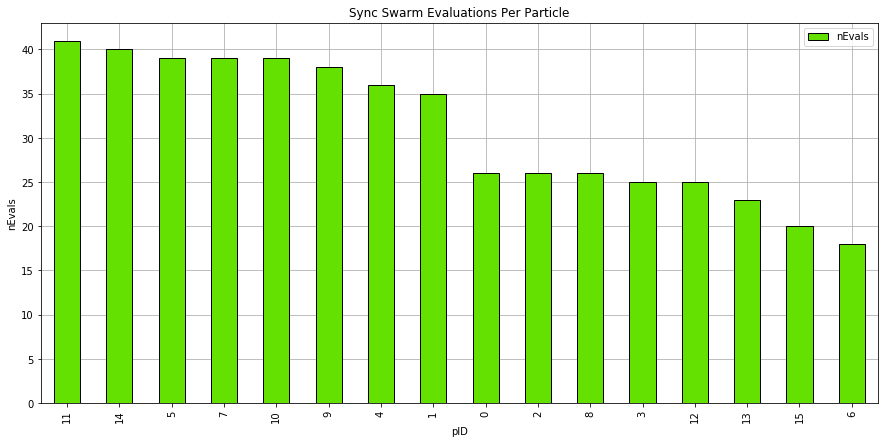

In [19]:
viz.plot_particle_evals( asyncSwarm )

In [20]:
viz.viz_particle_trails( asyncSwarm )

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://172.17.0.2:43566 remote=tcp://172.17.0.2:32823>


elapsed time 9.65


In [22]:
from cuml import ForestInference

In [23]:
?ForestInference.load

Signature:     
ForestInference.load(
    filename,
    output_class=False,
    threshold=0.5,
    algo='TREE_REORG',
    model_type='xgboost',
    handle=None,
)
Call signature: ForestInference.load(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction ForestInference.load at 0x7fac56c06270>
Docstring:     
ForestInference.load(filename, output_class=False, threshold=0.50, algo=u'TREE_REORG', model_type=u'xgboost', handle=None)

Returns a FIL instance containing the forest saved in 'filename'
This uses Treelite to load the saved model.

Parameters
----------
filename : str
   Path to saved model file in a treelite-compatible format
   (See https://treelite.readthedocs.io/en/latest/treelite-api.html
output_class : bool
   If true, return a 1 or 0 depending on whether the raw prediction
   exceeds the threshold. If False, just return the raw prediction.
threshold : float
   Cutoff value above which a prediction is set to 1.0
   Only used if the model is 

In [28]:
dataset.trainObjective[1]

In [70]:
syncSwarm.globalBest['nTrees']

35

In [71]:
xgboostParams = {
    'tree_method': 'gpu_hist',
    'random_state': 0, 
    'max_depth': int(syncSwarm.globalBest['params'][0]),
    'learning_rate': syncSwarm.globalBest['params'][1],
    'gamma': syncSwarm.globalBest['params'][2]
}
    
# objective [ binary or multi-class ]
xgboostParams['objective'] = dataset.trainObjective[0]
if dataset.trainObjective[1] is not None: xgboostParams['num_class'] = dataset.trainObjective[1]

In [72]:
startTime = time.time()

trainDMatrix = xgboost.DMatrix( data = dataset.trainData, label = dataset.trainLabels )
testDMatrix = xgboost.DMatrix( data = dataset.testData, label = dataset.testLabels )

In [73]:
trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], params = xgboostParams,
                                 num_boost_round = syncSwarm.globalBest['nTrees'])

trainDataPerf = 1 - float( trainedModelGPU.eval(trainDMatrix).split(':')[1] )
testDataPerf = 1 - float( trainedModelGPU.eval(testDMatrix).split(':')[1] )   

nTrees = trainedModelGPU.best_iteration

elapsedTime = time.time() - startTime

[0]	test-error:0.50050
[1]	test-error:0.50050
[2]	test-error:0.31560
[3]	test-error:0.30060
[4]	test-error:0.31320
[5]	test-error:0.17120
[6]	test-error:0.16250
[7]	test-error:0.13310
[8]	test-error:0.13250
[9]	test-error:0.12010
[10]	test-error:0.10560
[11]	test-error:0.08130
[12]	test-error:0.07320
[13]	test-error:0.07170
[14]	test-error:0.08420
[15]	test-error:0.05780
[16]	test-error:0.07830
[17]	test-error:0.05710
[18]	test-error:0.07220
[19]	test-error:0.05550
[20]	test-error:0.07180
[21]	test-error:0.05350
[22]	test-error:0.07050
[23]	test-error:0.05330
[24]	test-error:0.06970
[25]	test-error:0.05480
[26]	test-error:0.07030
[27]	test-error:0.05540
[28]	test-error:0.07480
[29]	test-error:0.05220
[30]	test-error:0.07140
[31]	test-error:0.05320
[32]	test-error:0.07270
[33]	test-error:0.05250
[34]	test-error:0.07500


In [74]:
trainedModelGPU.save_model('xgb.model')

In [75]:
ez = ForestInference.load('xgb.model')

In [100]:
%%time
results = ez.predict(dataset.testData.as_matrix().astype(np.float32))

CPU times: user 10.2 ms, sys: 3.45 ms, total: 13.6 ms
Wall time: 11.2 ms


In [ ]:
trainedModelGPU.p

In [81]:
sResults = cudf.Series(results)

In [85]:
sResults[sResults < 0] = 0
sResults[sResults > 0] = 1

In [99]:
sResults.to_array().astype(np.int32) ==  dataset.testLabels.as_matrix().squeeze().astype(np.int32)

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
1 -- concise [ simple ] 
    [  ]
    
2 -- relevant [ applicable in modern workflows ]
    [  ]

3 -- engaging [ visually appealing / ]
    [  ]

4 -- showcase strength of NVIDIA [ compute performance ]
    [  ] 




In [21]:
viz.viz_swarm( asyncSwarm, asyncSwarm.paramRanges )

# Inference:

TODO: time inference
TODO: time inference with forest opt

# Appendix

<img src="images/rapids_motivation.png" width="1000"/>

In [ ]:
# https://www.osgeo.cn/matplotlib/gallery/lines_bars_and_markers/timeline.html

# 10. Extensions

larger than single GPU memory datasets - dask_cudf + [ dask_xgboost or xgboost.dask ]

Async Scaling > Sync Scaling > Random Search

1. [ Generate a classification dataset on GPU ](#data-load) (e.g., double helix, unwinding helix/whirl )

2. [ ETL - process/prepare data for model training ](#ETL) (e.g., scale, split, augment )   
    
3. [ Define HPO Strategy ](#define-hpo)

4. [ Create Compute Cluster ](#compute-cluster)
   > LocalCUDACluster or KubeCluster
      
5. [ Define Seach ](#define-search)

6. [ Run ASYNC Particle Swarm ](#run-async-PSO)

7. [ Run Classic Particle Swarm ](#run-classic-PSO)

8. [ Run Random Search Baseline ](#run-random-search)

9. [ Summary ](#summary)

# User Choices:

The user is able to make several key choices in running this notebook. They are as follows:

1. [ Dataset ]()
2. [ Compute Scaling Strategy - Scale-Up, Scale-Out ]()
3. [ XGBoost Parameter Search Range ]()

4. [ Particle Swarm Type ]()
   * Synchronous
   * Asynchronous
   * Random Search